<a href="https://colab.research.google.com/github/agroimpacts/palmvolution/blob/main/notebooks/Transfer_Learning_Drone_Imagery_Sam_Jason.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Identifying oil palm in drone imagery**

Sam Levin, Jason Andrews, Brenner Burkholder, Ryan Freed

DSCI215/GEOG315 Spring 2023

##**1. Introduction:**

Our project focused on adapting a pre-trained model, initially designed for drone imagery of various crop types, to work with our oil palm imagery data. This process is known as transfer learning, and the advantage is that a model trained on another crop can still be helpful in identifying basic features of a landscape, such as field edges. Our goal was to understand how to load pre-trained model parameters from .pth files, how to use pickle files to store and read data, and how to fine-tune a pre-trained model for a specific task.


##**2. Methods:**

For our part of the project, we were working on performing transfer learning on a model that Hanxi Li, one of the grad students in our class, created. When we first started the project, Hanxi sent us his model that had already been run to produce pretrained weights. There were several .pth files to choose from, and we decided to use a file called with_drop_0.3_final_state.pth as our pre-trained model weights. 

Before we were able to start working on the transfer learning part of the project we had to create a custom data loader to load all the data from a CSV file that was provided for us, which Sam created. Eventually, it turned out that there were data files that were not properly added to the required folder, preventing us from using the data loader that Sam wrote to get all the data that we needed. Therefore, we ended up using a data loader that was provided for us to create two pickle files containing training (train_data_drone_new.pkl) and validation (validation_data_drone_new.pkl) data that we could then use for the transfer learning part of the project. The way we read in our data was through the use of pd.read_pickle(), which allowed us to seamlessly read in both our pickle files, which created dataframes for us that we could easily use in our code. 

While working on the project, we utilized code chunks and methods that we had learned to use from our previous five assignments to try and complete the project. To perform transfer learning on the provided pre-trained models, we used a class called ModelCompiler which had a helper function called load_params that we were able to incorporate to load our pre-trained model. From this, we used the load_params function inside ModelCompiler to visualize how many model layers we had, in order to understand how many layers to freeze, which is an important task in transfer learning. 

We then fitted our model to perform fine tuning to train the model on the new data that was provided via the pkl files mentioned earlier. Once training was complete we saved the model and performed some prediction to see how well the transfer learning model performed compared to the pre-trained model. 


## Loading Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%capture
!pip install rasterio
!pip install dill

In [ ]:
# Import the required libraries
# Numerical computation
import numpy as np
import numpy.ma as ma

# Structured data wrangling
import pandas as pd
import pickle as pkl
import dill

# Visualization
import matplotlib.pyplot as plt
import rasterio.plot as rp
from skimage import exposure

# Computer vision libraries
from sklearn import metrics
from skimage import transform as trans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import rasterio
from rasterio.windows import Window
from rasterio.plot import show

# General libraries
import itertools
from itertools import product
import random
import math
import numbers
import copy
import os
import glob
import gc
import re
from datetime import datetime, timedelta
from pathlib import Path
import collections
from collections import OrderedDict
import urllib.parse as urlparse
import queue
import threading
import multiprocessing as mp
from tqdm import tqdm

# DL package
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from torch.nn import init
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import Variable
from torch.autograd import Function
from torch.autograd.function import once_differentiable
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import torch.cuda.comm as comm
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.tensorboard import SummaryWriter

# Debugging library for jupyter notebook.
from IPython.core.debugger import set_trace

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Magic keywords for Ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

Checking CUDA availability

In [ ]:
print("PyTorch version: {}".format(torch.__version__))
print("Cuda version : {}".format(torch.version.cuda))
print('CUDNN version:', torch.backends.cudnn.version())
print('Number of available GPU Devices:', torch.cuda.device_count())
#print("current GPU Device: {}".format(torch.cuda.current_device()))

PyTorch version: 2.0.0+cu118
Cuda version : 11.8
CUDNN version: 8700
Number of available GPU Devices: 1


## Functions

#### Define Random Seed

In [ ]:
def seed_everything(seed = 1234, cudnn = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if cudnn:
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

seed_everything()

#### Plotting functions

##### Plot train valid loss curve

In [ ]:
def plot_curve (train, valid, line1, line2):
  plt.plot(np.arange(0, len(train)), train, label = "Train Loss")
  plt.plot(np.arange(0, len(train)), valid, label = "Validation Loss")
  plt.legend()
  min_train = np.round(train[-1], 3)
  max_train = np.round(train[0], 3)
  min_valid = np.round(valid[-1], 3)
  max_valid = np.round(valid[0], 3)
  plt.text(18, line1, f'Train Loss starts with:{max_train} and ends:{min_train}')
  plt.text(18, line2, f'Valid Loss starts with:{max_valid} and ends:{min_valid}')

  return plt.show()

##### Plot prediction img and label pairs

In [ ]:
def plot_predictions(img, pred, lbl, channel=0):
    """
    Plots an image chip alongside its prediction and label maps.

    Params:
      img (numpy array): Raster image to be displayed
      pred (numpy array): Prediction image to be displayed corresponding to img
      lbl (numpy array): Label image corresponding to img
      channel (int): Channel from this image to display out of the 3 bands. 
          Ensure that you do not exceed len(channels).

    Returns:
      fig, axs (plot): Pyplot graphic of the original image, its prediction map, 
      and label map.
    """
    # print("Image shape:", img.shape)
    # print("Prediction shape:", pred.shape)
    
    # print("Label shape:", lbl.shape)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    
    # Display the RGB image using imshow
    # img_rgb = img.transpose(1, 2, 0)
    # axs[0].imshow(img_rgb, )
    show(img, ax=axs[0], adjust=True)
    axs[0].set_title(f'Image {i+1}') #print(f"Image {i+1}:")
    axs[0].axis('off')

    pred_channel = pred.squeeze()
    axs[1].imshow(pred_channel, cmap='viridis')#, vmin=0, vmax=1)
    axs[1].set_title(f'Prediction {i+1} (Channel {channel})'.format(channel))
    axs[1].axis('off')

    # lbl_2_plot = lbl.squeeze().astype(float) / np.max(lbl)
    # axs[2].imshow(lbl_2_plot, cmap='jet', vmin=0, vmax=1)
    axs[2].imshow(lbl, cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title(f'Label {i+1}')
    axs[2].axis('off')

#### Image processing

##### Normalization

In [ ]:
### Image Normalization ###
def mmNorm(img, nodata):
    '''
    Data normalization with min/max method
    Params:
        img (narray): The targeted image for normalization
    Returns:
        narrray
    '''

    img_tmp = np.where(img == nodata, np.nan, img)
    img_max = np.nanmax(img_tmp)
    img_min = np.nanmin(img_tmp)
    normalized = (img - img_min)/(img_max - img_min)

    return normalized

# global z-score UPDATED 11:24 PM
def norm_img(img, means, stds):
    '''
    Data normalization with min/max method
    Params:
        img (narray): The targeted image for normalization
        means (array): Band means
        stds (array): Band standard deviations
    Returns:
        narrray
    '''
    img = img.astype(np.float32)
    normalized = np.empty(img.shape)
    for i in range(3):
        normalized[i, :, :] = (img[i, :, :] - means[i]) / stds[i]

    return normalized

##### Data loading utilities

In [ ]:
### Load data ####
# Let's use this version
def load_data(dataPath, usage="train", isLabel=False, 
              normalize=False, window=None, means=None, stds=None):
    '''
    Read geographic data into numpy array
    Params:
        dataPath (str): Path of data to load
        usage (str): Usage of the data: "train", "validate", or "predict"
        isLabel (bool): Decide whether to saturate data with tested threshold
        normalize (bool): Apply normalization or not
        window (tuple): The view onto a rectangular subset of the data, in the 
            format of (column offsets, row offsets, width in pixel, 
            height in pixel)
        means (tuple): tuple of means for normalization
        stds (tuple): tuple of stds for normalization        
        
    Returns:
        narray
    '''

    with rasterio.open(dataPath, "r") as src:
        meta = src.meta
        if isLabel:
            if src.count != 1:
                raise InputError("Label shape not applicable")
            img = src.read(1)
            # img = img.astype(np.int16)
            img = img[max(0, window[1]): window[1] + window[3], 
                      max(0, window[0]): window[0] + window[2]]

        else:
            nodata = src.nodata
            meta["dtype"] = "int16"
            if usage in ['train', 'validate']:
                # Norm by tile
                # img = mmNorm(src.read(), nodata=nodata)
                img = src.read()
                
                # replace NANs (hard-coded, should be removed)
                nans = np.isnan(img[2])
                if nans.any():
                    fill = np.nanmean(img[2])
                    img2 = np.where(nans, fill, img[2].copy())
                    img[2] = img2                
                
                # img = img.astype(np.int16)
                
                if normalize:
                    img = norm_img(img, means, stds)

                if window:    
                    img = img[:, max(0, window[1]): window[1] + window[3], 
                              max(0, window[0]): window[0] + window[2]]

            else:
                # Norm by tile
                # img = mmNorm(src.read(), nodata=nodata)
                img = src.read()
                if normalize:
                    img = norm_img(img, means, stds)
                # img = img.astype(np.int16)

                if window:    
                    img = img[:, max(0, window[1]): window[1] + window[3], 
                              max(0, window[0]): window[0] + window[2]]

    return img, meta

### stack images ###
def get_stacked_img(imgPaths, usage, window=None):
    '''
    Read geographic data into numpy array
    Params:
        gsPath (str): Path of growing season image
        osPath (str): Path of off season image
        imgPaths (list): List of paths for imgages
        usage (str): Usage of the image: "train", "validate", or "predict"
        window (tuple): The view onto a rectangular subset of the data, in 
            the format of (column offsets, row offsets, width in pixel, 
            height in pixel)
    Returns:
        narray
    '''

    img_ls = [load_data(m, window=window, usage=usage) for m in imgPaths]
    img = np.concatenate(img_ls, axis=0).transpose(1, 2, 0)

    if usage in ["train", "validate"]:
        col_off, row_off, col_target, row_target=window
        row, col, c = img.shape

        if row < row_target or col < col_target:

            row_off = abs(row_off) if row_off < 0 else 0
            col_off = abs(col_off) if col_off < 0 else 0

            canvas = np.zeros((row_target, col_target, c))
            canvas[row_off: row_off + row, col_off : col_off + col, :] = img

            return canvas

        else:
            return img

    elif usage == "predict":
        return img

    else:
        raise ValueError

### Get buffered window ####

def get_buffered_window(srcPath, dstPath, buffer):
    '''
    Get bounding box representing subset of source image that overlaps with 
    bufferred destination image, in format of (column offsets, row offsets, 
    width, height)
    Params:
        srcPath (str): Path of source image to get subset bounding box
        dstPath (str): Path of destination image as a reference to define the
            bounding box. Size of the bounding box is (destination width + 
            buffer * 2, destination height + buffer * 2)
        buffer (int): Buffer distance of bounding box edges to destination image 
            measured by pixel numbers
    Returns:
        tuple in form of (column offsets, row offsets, width, height)
    '''

    with rasterio.open(srcPath, "r") as src:
        gt_src = src.transform

    with rasterio.open(dstPath, "r") as dst:
        gt_dst = dst.transform
        w_dst = dst.width
        h_dst = dst.height

    col_off = round((gt_dst[2] - gt_src[2]) / gt_src[0]) 
    row_off = round((gt_dst[5] - gt_src[5]) / gt_src[4])
    width = w_dst 
    height = h_dst 

    return col_off, row_off, width, height

### Get meta from bounds ###
def get_meta_from_bounds(file, buffer):
    '''
    Get metadata of unbuffered region in given file
    Params:
        file (str):  File name of a image chip
        buffer (int): Buffer distance measured by pixel numbers
    Returns:
        dictionary
    '''

    with rasterio.open(file, "r") as src:

        meta = src.meta
        dst_width = src.width  
        dst_height = src.height 

        window = Window(buffer, buffer, dst_width, dst_height)
        # print(src.transform)
        win_transform = src.window_transform(window)
        # print(win_transform)

    meta.update({
        'width': dst_width,
        'height': dst_height,
        'transform': win_transform#,
        # 'count': 1,
        # 'nodata': -128,
        # 'dtype': 'int8'
    })

    return meta

### Get Chips ###
def get_chips(img, dsize, buffer):
    '''
    Generate small chips from input images and the corresponding index of each 
    chip The index marks the location of corresponding upper-left pixel of a 
    chip.
    
    Params:
        img (narray): Image in format of (H,W,C) to be crop, in this case it is 
            the concatenated image of growing season and off season
        dsize (int): Cropped chip size
        buffer (int):Number of overlapping pixels when extracting images chips
    Returns:
        list of cropped chips and corresponding coordinates
    '''

    h, w, _ = img.shape
    x_ls = range(0, h - 2 * buffer, dsize - 2 * buffer)
    y_ls = range(0, w - 2 * buffer, dsize - 2 * buffer)

    index = list(itertools.product(x_ls, y_ls))

    img_ls = []
    for i in range(len(index)):
        x, y = index[i]
        img_ls.append(img[x:x + dsize, y:y + dsize, :])

    return img_ls, index

### Input Error handling ###
class InputError(Exception):
    '''
    Exception raised for errors in the input
    '''

    def __init__(self, message):
        '''
        Params:
            message (str): explanation of the error
        '''

        self.message = message

    def __str__(self):
        '''
        Define message to return when error is raised
        '''

        if self.message:
            return 'InputError, {} '.format(self.message)
        else:
            return 'InputError'


## Code from Sam ###
############################

def load_data2(dataPath, usage="predict", isLabel=False, 
              normalize=False, window=None, means=None, stds=None):
    '''
    Read geographic data into numpy array
    Params:
        dataPath (str): Path of data to load
        usage (str): Usage of the data: "train", "validate", or "predict"
        isLabel (bool): Decide whether to saturate data with tested threshold
        normalize (bool): Apply normalization or not
        window (tuple): The view onto a rectangular subset of the data, in the 
            format of (column offsets, row offsets, width in pixel, 
            height in pixel)
        means (tuple): tuple of means for normalization
        stds (tuple): tuple of stds for normalization        
        
    Returns:
        narray
    '''

    with rasterio.open(dataPath, "r") as src:
        if isLabel:
            if src.count != 1:
                raise InputError("Label shape not applicable")
            lbl = src.read(1)
            lbl = lbl[max(0, window[1]): window[1] + window[3], 
                      max(0, window[0]): window[0] + window[2]]
            return lbl
            
        else:
            nodata = src.nodata
            meta = src.meta
            meta["dtype"] = "int16"

            if usage in ['train', 'validate']:
                # Norm by tile
                img = src.read()
                
                # replace NANs (hard-coded, should be removed)
                nans = np.isnan(img[2])
                if nans.any():
                    fill = np.nanmean(img[2])
                    img2 = np.where(nans, fill, img[2].copy())
                    img[2] = img2                
                                
                if normalize:
                    img = norm_img(img, means, stds)
                    
                img = img[:, max(0, window[1]): window[1] + window[3], 
                          max(0, window[0]): window[0] + window[2]]

            else:
                # Norm by tile
                img = src.read()
                if normalize:
                    img = norm_img(img, means, stds)

    return img, meta

##### Image Augmentation

In [ ]:
#### Random Rotation around the center ###
def centerRotate(img, label, degree):
    '''
    Synthesize new image chips by rotating the input chip around its center.
    Args:
    img (narray): Concatenated variables or brightness value with a dimension of (H, W, C)
    label (narray): Ground truth with a dimension of (H,W)
    mask (narray): Binary mask represents valid pixels in images and label, in a dimension of (H,W)
    degree (tuple or list): Range of degree for rotation
    Returns:
    (narray, narray, narray) tuple of rotated image, label and mask
    '''

    if isinstance(degree, tuple) or isinstance(degree, list):
        degree = random.uniform(degree[0], degree[1])

    # Get the dimensions of the image (e.g. number of rows and columns).
    h, w, _ = img.shape

    # Determine the image center.
    center = (w // 2, h // 2)

    # Grab the rotation matrix
    rotMtrx = cv2.getRotationMatrix2D(center, degree, 1.0)

    # perform the actual rotation for both raw and labeled image.
    img = cv2.warpAffine(img, rotMtrx, (w, h))
    label = cv2.warpAffine(label, rotMtrx, (w, h))
    label = np.rint(label)

    return img, label

### Horizontal, Vertical and Diagonal Flip ###
def flip(img, label, ftype):
    '''
    Synthesize new image chips by flipping the input chip around a user defined 
    axis.
    Args:
        img (narray): Concatenated variables or brightness value with a 
            dimension of (H, W, C)
        label (narray): Ground truth with a dimension of (H,W)
        mask (narray): Binary mask represents valid pixels in images and 
            label, in a dimension of (H,W)
        ftype (str): Flip type from ['vflip','hflip','dflip']
    Returns:
        (narray, narray, narray) tuple of flipped image, label and mask
    Note:
        Provided transformation are:
            1) 'vflip', vertical flip
            2) 'hflip', horizontal flip
            3) 'dflip', diagonal flip
    '''

    def diagonal_flip(img):
        flipped = np.flip(img, 1)
        flipped = np.flip(flipped, 0)
        return flipped


    # Horizontal flip
    if ftype == 'hflip':

        img = np.flip(img, 0)
        label = np.flip(label, 0)

    # Vertical flip
    elif ftype == 'vflip':

        img = np.flip(img, 1)
        label = np.flip(label, 1)

    # Diagonal flip
    elif ftype == 'dflip':

        img = diagonal_flip(img)
        label = diagonal_flip(label)

    else:

        raise ValueError("Bad flip type")

    return img.copy(), label.copy()

### Random Rescaling of image chips ###
def reScale(img, label, scale=(0.8, 1.2), randResizeCrop=False, 
            diff=False, cenLocate=True):
    '''
    Synthesize new image chips by rescaling the input chip.
    Params:
        img (narray): Concatenated variables or brightness value with a 
            dimension of (H, W, C)
        label (narray): Ground truth with a dimension of (H,W)
        mask (narray): Binary mask represents valid pixels in images and
            label, in a dimension of (H,W)
        scale (tuple or list): Range of scale ratio
        randResizeCrop (bool): Whether crop the rescaled image chip 
            randomly or at the center if the chip is larger than inpput ones
        diff (bool): Whether change the aspect ratio
        cenLocate (bool): Whether locate the rescaled image chip at the center
            or a random position if the chip is smaller than input
    Returns:
        (narray, narray, narray) tuple of rescaled image, label and mask
    '''

    h, w, _ = img.shape
    if isinstance(scale, tuple) or isinstance(scale, list):
        resizeH = round(random.uniform(scale[0], scale[1]) * h)
        if diff:
            resizeW = round(random.uniform(scale[0], scale[1]) * w)
        else:
            resizeW = resizeH
    else:
        raise Exception('Wrong scale type!')

    imgRe = trans.resize(img, (resizeH, resizeW), preserve_range=True)
    labelRe = trans.resize(label, (resizeH, resizeW), preserve_range=True)


    # crop image when length of side is larger than input ones
    if randResizeCrop:
        x_off = random.randint(0, max(0, resizeH - h))
        y_off = random.randint(0, max(0, resizeW - w))
    else:
        x_off = max(0, (resizeH - h) // 2)
        y_off = max(0, (resizeW - w) // 2)

    imgRe = imgRe[x_off:x_off + min(h, resizeH), y_off:y_off + min(w, resizeW), :]
    labelRe = labelRe[x_off:x_off + min(h, resizeH), y_off:y_off + min(w, resizeW)]
    labelRe = np.rint(labelRe)

    # locate image when it is smaller than input
    if resizeH < h or resizeW < w:
        if cenLocate:
            tlX = max(0, (h - resizeH) // 2)
            tlY = max(0, (w - resizeW) // 2)
        else:
            tlX = random.randint(0, max(0, h - resizeH))
            tlY = random.randint(0, max(0, w - resizeW))

        # resized result
        imgRe, labelRe = uniShape(imgRe, labelRe, h, tlX, tlY)

    return imgRe, labelRe

### Change pixel brightness to account for atmospheric and ### 
### illumination noise  ###
def shiftBrightness(img, gammaRange=(0.2, 2.0), shiftSubset=(4, 4), 
                    patchShift=True):
    '''
    Shift image brightness through gamma correction
    Params:
        img (narray): Concatenated variables or brightness value with a
            dimension of (H, W, C)
        gammaRange (tuple): Range of gamma values
        shiftSubset (tuple): Number of bands or channels for each shift
        patchShift (bool): Whether apply the shift on small patches
     Returns:
        narray, brightness shifted image
    '''


    c_start = 0

    if patchShift:
        for i in shiftSubset:
            gamma = random.triangular(gammaRange[0], gammaRange[1], 1)

            h, w, _ = img.shape
            rotMtrx = cv2.getRotationMatrix2D(
                center=(random.randint(0, h), random.randint(0, w)),
                angle=random.randint(0, 90), scale=random.uniform(1, 2)
            )
          
            # default extra step -- shift on image
            gamma_full = random.triangular(0.5, 1.5, 1)
            img[:, :, c_start:c_start + i] = np.power(
                img[:, :, c_start:c_start + i], gamma_full
            )

            c_start += i
    else:
        # convert image dimension to (C, H, W) if len(img.shape)==3
        img = np.transpose(
            img, list(range(img.ndim)[-1:]) + list(range(img.ndim)[:-1])
        )
        for i in shiftSubset:
            gamma = random.triangular(gammaRange[0], gammaRange[1], 1)
            img[c_start:c_start + i, ] = np.power(
                img[c_start:c_start + i, ], gamma
            )

            c_start += i
        img = np.transpose(img, list(range(img.ndim)[-img.ndim + 1:]) + [0])

    return img

### Unify image and label chips dimensions ###
def uniShape(img, label, dsize, tlX=0, tlY=0):

    '''
    Unify dimension of images and labels to specified data size
    Params:
    img (narray): Concatenated variables or brightness value with a dimension 
        of (H, W, C)
    label (narray): Ground truth with a dimension of (H,W)
    mask (narray): Binary mask represents valid pixels in images and label, 
        in a dimension of (H,W)
    dsize (int): Target data size
    tlX (int): Vertical offset by pixels
    tlY (int): Horizontal offset by pixels
    Returns:
    (narray, narray, narray) tuple of shape unified image, label and mask
    '''

    resizeH, resizeW, c = img.shape

    canvas_img = np.zeros((dsize, dsize, c), dtype=img.dtype)
    canvas_label = np.zeros((dsize, dsize), dtype=label.dtype)

    canvas_img[tlX:tlX + resizeH, tlY:tlY + resizeW] = img
    canvas_label[tlX:tlX + resizeH, tlY:tlY + resizeW] = label

    return canvas_img, canvas_label

#### Model functions

##### Learning rate policies


In [ ]:
### Polynomial Learning rate Decay Policy ###
class PolynomialLR(_LRScheduler):
    """Polynomial learning rate decay until step reach to max_decay_step
    
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        max_decay_steps: after this step, we stop decreasing learning rate
        min_learning_rate: scheduler stoping learning rate decay, value of 
            learning rate must be this value
        power: The power of the polynomial.
    """
    
    def __init__(self, optimizer, max_decay_steps, min_learning_rate=1e-5, 
                 power=1.0):
        
        if max_decay_steps <= 1.:
            raise ValueError('max_decay_steps should be greater than 1.')
        
        self.max_decay_steps = max_decay_steps
        self.min_learning_rate = min_learning_rate
        self.power = power
        self.last_step = 0
        
        super().__init__(optimizer)
        
    def get_lr(self):
        if self.last_step > self.max_decay_steps:
            return [self.min_learning_rate for _ in self.base_lrs]

        return [(base_lr - self.min_learning_rate) * 
                ((1 - self.last_step / self.max_decay_steps) ** (self.power)) + 
                self.min_learning_rate for base_lr in self.base_lrs]
    
    def step(self, step=None):
        
        if step is None:
            step = self.last_step + 1
        self.last_step = step if step != 0 else 1
        
        if self.last_step <= self.max_decay_steps:
            decay_lrs = [
                (base_lr - self.min_learning_rate) * 
                ((1 - self.last_step / self.max_decay_steps) ** (self.power)) + 
                self.min_learning_rate for base_lr in self.base_lrs
            ]
            
            for param_group, lr in zip(self.optimizer.param_groups, decay_lrs):
                param_group['lr'] = lr

### Reading the dataframe input with parallel workers ###
def parallelize_df(df, func, n_cores=os.cpu_count(), **kwargs):
    '''
    Processes specified method on pandas dataframe using multiple cores
    Params:
        df (''pd.DataFrames''): Pandas dataframe to be processed
        func: Method to apply on provided dataframe
        n_cores (int): Number of processes that the mother process splits into
    Returns:
        ''pd.DataFrames''
    '''

    n_cores = min(n_cores, len(df))    
    other_args = [kwargs['{}'.format(m)] for m in func.__code__.co_varnames[1:]]
    df_split = np.array_split(df, n_cores)
    
    pool = mp.Pool(n_cores)
    df_map = pool.starmap(func, product(df_split, *[[m] for m in other_args]))

    df = pd.concat(df_map)
    pool.close()
    pool.join()

    return df

### Multi-core ###

def multicore(func, args, n_cores=os.cpu_count()):
    '''
    Processes specified method on a series of arguments in parallel. Number of 
    cores is determined by whichever is smaller of the computer cores or the 
    arguments nubmer.
    Params:
        fuc: function to apply on provided arguments
        args (list): a list of independent arguments
    '''

    n_cores = min(n_cores, len(args))
    pool = mp.Pool(processes=n_cores)
    pool.map(func, args)
    pool.close()
    pool.join()

##### Loss Function

In [ ]:
### Balanced Cross Entropy Loss ###
class BalancedCrossEntropyLoss(nn.Module):
    r'''
    Cross Entropy loss weighted based on inverse class ratio strategy.
    
    Arguments:
        ignore_index (int) -- Class index to ignore
        reduction (str) -- Reduction method to apply, return mean over batch if 'mean',
                         return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    '''

    def __init__(self, ignore_index=-100, reduction='mean'):
        super(BalancedCrossEntropyLoss, self).__init__()
        
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, predict, target):
        # get class weights
        unique, unique_counts = torch.unique(target, return_counts=True)
        
        # calculate weight for only valid indices
        unique_counts = unique_counts[unique != self.ignore_index]
        unique = unique[unique != self.ignore_index]
        ratio = unique_counts.float() / torch.numel(target)
        weight = (1. / ratio) / torch.sum(1. / ratio)

        lossWeight = torch.ones(predict.shape[1]).cuda() * 0.00001
        
        for i in range(len(unique)):
            lossWeight[unique[i]] = weight[i]
        
        loss = nn.CrossEntropyLoss(weight=lossWeight, ignore_index=self.ignore_index, reduction=self.reduction)

        return loss(predict, target)

### Dice Loss Family ###
class BinaryDiceLoss(nn.Module):
    r'''
    Dice loss of binary classes.
    Arguments:
        smooth (float): A float number to smooth loss, and avoid NaN error, default: 1
        p (int): Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict (torch.tensor): Predicted tensor of shape [N, *]
        target (torch.tensor): Target tensor of same shape with predict
    Returns:
        Loss tensor
    '''

    def __init__(self, smooth=1, p=1):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size do not match"
        predict = predict.contiguous().view(-1)
        target = target.contiguous().view(-1)

        num = 2 * (predict * target).sum() + self.smooth
        den = (predict.pow(self.p) + target.pow(self.p)).sum() + self.smooth
        loss = 1 - num / den

        return loss

###
class DiceLoss(nn.Module):
    r'''
    Dice loss
    
    Arguments:
        weight (torch.tensor): Weight array of shape [num_classes,]
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
        other args pass to BinaryDiceLoss
    Returns:
        same as BinaryDiceLoss
    '''

    def __init__(self, weight=None, ignore_index=-100, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        nclass = predict.shape[1]
        if predict.shape == target.shape:
            pass
        elif len(predict.shape) == 4:
            target = F.one_hot(target, num_classes=nclass).permute(0, 3, 1, 2).contiguous()
        else:
            assert 'Predict tensor shape of {} is not assceptable.'.format(predict.shape)

        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        weight = torch.Tensor([1. / nclass] * nclass).cuda() if self.weight is None else self.weight
        predict = F.softmax(predict, dim=1)

        for i in range(nclass):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])

                assert weight.shape[0] == nclass, \
                    'Expected weight tensor with shape [{}], but got[{}]'.format(nclass, weight.shape[0])
                dice_loss *= weight[i]
                total_loss += dice_loss

        return total_loss

###
class BalancedDiceLoss(nn.Module):
    r'''
    Dice Loss weighted by inverse of label frequency
    Arguments:
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
        other args pass to BinaryDiceLoss
    Returns:
        same as BinaryDiceLoss
    '''

    def __init__(self, ignore_index=-100, **kwargs):
        super(BalancedDiceLoss, self).__init__()
        self.kwargs = kwargs
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        # get class weights
        unique, unique_counts = torch.unique(target, return_counts=True)
        # calculate weight for only valid indices
        unique_counts = unique_counts[unique != self.ignore_index]
        unique = unique[unique != self.ignore_index]
        ratio = unique_counts.float() / torch.numel(target)
        weight = (1. / ratio) / torch.sum(1. / ratio)

        lossWeight = torch.ones(predict.shape[1]).cuda() * 0.00001
        for i in range(len(unique)):
            lossWeight[unique[i]] = weight[i]

        loss = DiceLoss(weight=lossWeight, ignore_index=self.ignore_index, **self.kwargs)

        return loss(predict, target)

###
class DiceCELoss(nn.Module):
    '''
    Combination of dice loss and cross entropy loss through summation
    
    Arguments:
        loss_weight (tensor): a manual rescaling weight given to each class. If given, has to be a Tensor of size C
        dice_weight (float): Weight on dice loss for the summation, while weight on cross entropy loss is
                             (1 - dice_weight)
        dice_smooth (float): A float number to smooth dice loss, and avoid NaN error, default: 1
        dice_p (int): Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        ignore_index (int): Class index to ignore
    Returns:
        Loss tensor
    '''

    def __init__(self, loss_weight = None, dice_weight=0.5 , dice_smooth=1, dice_p=1, ignore_index=-100):
        super(DiceCELoss, self).__init__()
        self.loss_weight = loss_weight
        self.dice_weight = dice_weight
        self.dice_smooth = dice_smooth
        self.dice_p = dice_p
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size do not match"

        dice = DiceLoss(weight=self.loss_weight, ignore_index=self.ignore_index, smooth=self.dice_smooth, p=self.dice_p)
        ce = nn.CrossEntropyLoss(weight=self.loss_weight, ignore_index=self.ignore_index)
        loss = self.dice_weight * dice(predict, target) + (1 - self.dice_weight) * ce(predict, target)

        return loss

###
class BalancedDiceCELoss(nn.Module):
    r'''
    Dice Cross Entropy weighted by inverse of label frequency
    Arguments:
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
        other args pass to DiceCELoss, excluding loss_weight
    Returns:
        Same as DiceCELoss
    '''

    def __init__(self, ignore_index=-100, **kwargs):
        super(BalancedDiceCELoss, self).__init__()
        self.ignore_index =  ignore_index
        self.kwargs = kwargs

    def forward(self, predict, target):
        # get class weights
        unique, unique_counts = torch.unique(target, return_counts=True)
        # calculate weight for only valid indices
        unique_counts = unique_counts[unique != self.ignore_index]
        unique = unique[unique != self.ignore_index]
        ratio = unique_counts.float() / torch.numel(target)
        weight = (1. / ratio) / torch.sum(1. / ratio)

        lossWeight = torch.ones(predict.shape[1]).cuda() * 0.00001
        for i in range(len(unique)):
            lossWeight[unique[i]] = weight[i]

        loss = DiceCELoss(loss_weight=lossWeight, **self.kwargs)

        return loss(predict, target)

### Tversky-Focal Loss Family ###
class BinaryTverskyFocalLoss(nn.Module):
    r'''
    Pytorch versiono of tversky focal loss proposed in paper
    'A novel focal Tversky loss function and improved Attention U-Net for lesion segmentation'
    (https://arxiv.org/abs/1810.07842)
    
    Arguments:
        smooth (float): A float number to smooth loss, and avoid NaN error, default: 1
        alpha (float): Hyperparameters alpha, paired with (1 - alpha) to shift emphasis to improve recall
        gamma (float): Tversky index, default: 1.33
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
    
    Returns:
        Loss tensor
    '''

    def __init__(self, smooth=1, alpha=0.7, gamma=1.33):
        super(BinaryTverskyFocalLoss, self).__init__()
        self.smooth = smooth
        self.alpha = alpha
        self.beta = 1 - self.alpha
        self.gamma = gamma


    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size do not match"

        # no reduction, same as original paper
        predict = predict.contiguous().view(-1)
        target = target.contiguous().view( -1)

        num = (predict * target).sum() + self.smooth
        den = (predict * target).sum() + self.alpha * ((1 - predict) * target).sum() \
              + self.beta * (predict * (1 - target)).sum() + self.smooth
        loss = torch.pow(1 - num/den, 1 / self.gamma)

        return loss
            
###
class TverskyFocalLoss(nn.Module):
    r'''
    Tversky focal loss
    
    Arguments:
        weight (torch.tensor): Weight array of shape [num_classes,]
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
        other args pass to BinaryTverskyFocalLoss
    Returns:
        same as BinaryTverskyFocalLoss
    '''
    def __init__(self, weight=None, ignore_index=-100, **kwargs):
        super(TverskyFocalLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        nclass = predict.shape[1]
        if predict.shape == target.shape:
            pass
        elif len(predict.shape) == 4:
            target = F.one_hot(target, num_classes=nclass).permute(0, 3, 1, 2).contiguous()
        else:
            assert 'predict shape not applicable'

        tversky = BinaryTverskyFocalLoss(**self.kwargs)
        total_loss = 0
        weight = torch.Tensor([1./nclass] * nclass).cuda() if self.weight is None else self.weight
        predict = F.softmax(predict, dim=1)
        
        for i in range(nclass):
            if i != self.ignore_index:
                tversky_loss = tversky(predict[:, i], target[:, i])
                assert weight.shape[0] == nclass, \
                    'Expect weight shape [{}], get[{}]'.format(nclass, weight.shape[0])
                tversky_loss *= weight[i]
                total_loss += tversky_loss
            
        return total_loss

###
class BalancedTverskyFocalLoss(nn.Module):
    r'''  
    Tversky focal loss weighted by inverse of label frequency
    Arguments:
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
        other args pass to BinaryTverskyFocalLoss
    Returns:
        same as TverskyFocalLoss
    '''

    def __init__(self, ignore_index=-100, **kwargs):
        super(BalancedTverskyFocalLoss, self).__init__()
        self.kwargs = kwargs
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        # get class weights
        unique, unique_counts = torch.unique(target, return_counts=True)
        # calculate weight for only valid indices
        unique_counts = unique_counts[unique != self.ignore_index]
        unique = unique[unique != self.ignore_index]
        ratio = unique_counts.float() / torch.numel(target)
        weight = (1. / ratio) / torch.sum(1. / ratio)

        lossWeight = torch.ones(predict.shape[1]).cuda() * 0.00001
        for i in range(len(unique)):
                lossWeight[unique[i]] = weight[i]

        # loss
        loss = TverskyFocalLoss(weight=lossWeight, ignore_index=self.ignore_index, **self.kwargs)

        return loss(predict, target)

###
class TverskyFocalCELoss(nn.Module):
    '''
    Combination of tversky focal loss and cross entropy loss though summation
    Arguments:
        loss_weight (tensor): a manual rescaling weight given to each class. If given, has to be a Tensor of size C
        tversky_weight (float): Weight on tversky focal loss for the summation, while weight on cross entropy loss
                                is (1 - tversky_weight)
        tversky_smooth (float): A float number to smooth tversky focal loss, and avoid NaN error, default: 1
        tversky_alpha (float):
        tversky_gamma (float):
        ignore_index (int): Class index to ignore
    Returns:
        Loss tensor
    '''

    def __init__(self, loss_weight=None, tversky_weight=0.5, tversky_smooth=1, tversky_alpha=0.7, 
                 tversky_gamma=0.9, ignore_index=-100):
        super(TverskyFocalCELoss, self).__init__()
        self.loss_weight = loss_weight
        self.tversky_weight = tversky_weight
        self.tversky_smooth = tversky_smooth
        self.tversky_alpha = tversky_alpha
        self.tversky_gamma = tversky_gamma
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size do not match"

        tversky = TverskyFocalLoss(weight=self.loss_weight, ignore_index=self.ignore_index, smooth=self.tversky_smooth,
                                   alpha=self.tversky_alpha, gamma=self.tversky_gamma)
        ce = nn.CrossEntropyLoss(weight=self.loss_weight, ignore_index=self.ignore_index)
        loss = self.tversky_weight * tversky(predict, target) + (1 - self.tversky_weight) * ce(predict, target)

        return loss

###
class BalancedTverskyFocalCELoss(nn.Module):
    r'''
    Combination of tversky focal loss and cross entropy loss weighted by inverse of label frequency
    
    Arguments:
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
        other args pass to DiceCELoss, excluding loss_weight
    Returns:
        Same as TverskyFocalCELoss
    '''

    def __init__(self, ignore_index=-100, **kwargs):
        super(BalancedTverskyFocalCELoss, self).__init__()
        self.ignore_index =  ignore_index
        self.kwargs = kwargs

    def forward(self, predict, target):
        # get class weights
        unique, unique_counts = torch.unique(target, return_counts=True)
        # calculate weight for only valid indices
        unique_counts = unique_counts[unique != self.ignore_index]
        unique = unique[unique != self.ignore_index]
        ratio = unique_counts.float() / torch.numel(target)
        weight = (1. / ratio) / torch.sum(1. / ratio)

        lossWeight = torch.ones(predict.shape[1]).cuda() * 0.00001
        for i in range(len(unique)):
            lossWeight[unique[i]] = weight[i]

        loss = TverskyFocalCELoss(loss_weight=lossWeight, **self.kwargs)

        return loss(predict, target)

##### Evaluation Metrics

In [ ]:
class BinaryMetrics:
    '''
    Metrics measuring model performance.
    '''

    def __init__(self, refArray, scoreArray, predArray=None):
        '''
        Params:
            refArray (narray): Array of ground truth
            scoreArray (narray): Array of pixels scores of positive class
            predArray (narray): Boolean array of predictions telling whether a pixel belongs to a specific class
        '''

        self.eps = 10e-6
        self.observation = refArray.flatten()
        self.score = scoreArray.flatten()
        if predArray is not None:
            self.prediction = predArray.flatten()
        # take score over 0.5 as prediction if predArray not provided
        else:
            self.prediction = np.where(self.score > 0.5, 1, 0)
        self.confusion_matrix = self.confusion_matrix()

        if self.observation.shape != self.score.shape:
            raise InputError("Inconsistent input shape")

    def __add__(self, other):
        """
        Add two BinaryMetrics instances
        Params:
            other (''BinaryMetrics''): A BinaryMetrics instance
        Return:
            ''BinaryMetrics''
        """

        return BinaryMetrics(np.append(self.observation, other.observation),
                             np.append(self.score, other.score),
                            np.append(self.prediction, other.prediction))


    def __radd__(self, other):
        """
        Add a BinaryMetrics instance with reversed operands
        Params:
            other
        Returns:
            ''BinaryMetrics
        """

        if other == 0:
            return self
        else:
            return self.__add__(other)


    def confusion_matrix(self):
        """
        Calculate confusion matrix of given ground truth and predicted label
        Returns:
            ''pandas.dataframe'' of observation on the column and prediction on the row
        """

        refArray = self.observation
        predArray = self.prediction

        if refArray.max() > 1 or predArray.max() > 1:
            raise Exception("Invalid array")
        predArray = predArray * 2
        sub = refArray - predArray

        self.tp = np.sum(sub == -1)
        self.fp = np.sum(sub == -2)
        self.fn = np.sum(sub == 1)
        self.tn = np.sum(sub == 0)

        confusionMatrix = pd.DataFrame(data=np.array([[self.tn, self.fp], [self.fn, self.tp]]),
                                       index=['observation = 0', 'observation = 1'],
                                       columns = ['prediction = 0', 'prediction = 1'])
        return confusionMatrix


    def iou(self):
        """
        Calculate interception over union
        Returns:
            float
        """

        return metrics.jaccard_score(self.observation, self.prediction)


    def precision(self):
        """
        Calculate precision
        Returns:
            float
        """

        return metrics.precision_score(self.observation, self.prediction)


    def recall(self):
        """
        Calculate recall
        Returns:
            float
        """

        return metrics.recall_score(self.observation, self.prediction)


    def accuracy(self):
        """
        Calculate accuracy
        Returns:
            float
        """

        return metrics.accuracy_score(self.observation, self.prediction)


    def tss(self):
        """
        Calculate true scale statistic (TSS)
        Returns:
            float
        """

        return self.tp / (self.tp + self.fn) + self.tn / (self.tn + self.fp) - 1


    def false_positive_rate(self):
        """
        Calculate false positive rate
        Returns:
             float
        """

        return self.fp / (self.tn + self.fp)

    def F1_measure(self):
        """
        Calculate F1 score.
        Returns:
            float
        """

        try:
            precision = self.tp / (self.tp + self.fp)
            recall = self.tp / (self.tp + self.fn)
            f1 = (2 * precision * recall) / (precision + recall)

        except ZeroDivisionError:
            precision = self.tp / (self.tp + self.fp + self.eps)
            recall = self.tp / (self.tp + self.fn + self.eps)
            f1 = (2 * precision * recall) / (precision + recall + self.eps)

        return f1


    def area_under_roc(self):
        """
        Compute Area Under the Curve (AUC)
        Returns:
            float
        """

        return metrics.roc_auc_score(self.observation, self.score)
    
##################################################

def evaluate(evalData, model, buffer, gpu, csv_fn):
    """
    Evaluate model
    Params:
        evalData (''DataLoader''): Batch grouped data
        model: Trained model for validation
        buffer: Buffer added to the targeted grid when creating dataset. This allows metrics to calculate only
            at non-buffered region
        gpu (binary,optional): Decide whether to use GPU, default is True
        csv_fn (str): filename to save metrics

    """
    buffer = 0

    model.eval()

    metrics = []
    
    for img, label in evalData:
        img = Variable(img, requires_grad=False)
        label = Variable(label, requires_grad=False)

        # GPU setting
        if gpu:
            img = img.cuda()
            label = label.cuda()
        out = model(img)

        # Compute metrics
        out = F.softmax(out, 1)
        batch, nclass, height, width = out.size()

        for i in range(batch):
            label_batch = label[i, :, :].cpu().numpy()
            batch_predict = out.max(dim=1)[1][:, :, :].data[i].cpu().numpy()
            for n in range(nclass):
                class_out = out[:, n, :, :].data[i].cpu().numpy()
                class_predict = np.where(batch_predict == n, 1, 0)
                class_label = np.where(label_batch == n, 1, 0)
                metrics_chip = BinaryMetrics(class_label, class_out, class_predict)
                # append if exists
                try:
                    metrics[n].append(metrics_chip)
                except:
                    metrics.append([metrics_chip])
    print("start")
    # def gather_m(m):
    #     m_add = m[0]
    #     for i in range(1, len(m)):
    #         m_add = m_add + m[i]
    #     return m_add
    # metrics = [gather_m(m) for m in metrics]
    metrics = [sum(m) for m in metrics]
    
    print(len(metrics))
    report = pd.DataFrame({
        'tss': [m.tss() for m in metrics],
        'accuracy': [m.accuracy() for m in metrics],
        'precision': [m.precision() for m in metrics],
        'recall': [m.recall() for m in metrics],
        'fpr': [m.false_positive_rate() for m in metrics],
        'F1-score': [m.F1_measure() for m in metrics],
        'IoU': [m.iou() for m in metrics],
        'AUC': [m.area_under_roc() for m in metrics]
    }, index=["class_{}".format(m) for m in range(len(metrics))])
    
    print(report)
    report.to_csv(csv_fn)

##### Custom Data Class

In [ ]:
def pickle_dataset(dataset, file_path):
    try:
        with open(file_path, "wb") as fp:
            pkl.dump(dataset, fp)
        print(f"Dataset pickled and saved to {file_path}")
    except OSError as e:
        print(f"Error: could not open file {file_path}: {e}")
    except pkl.PickleError as e:
        print(f"Error: could not pickle dataset: {e}")


def load_pickled_dataset(file_path):
    """
    Load pickled dataset from file path.
    """
    dataset = pd.read_pickle(file_path)
    return dataset

##### Loader

In [ ]:
## droneDataLoader
class droneDataLoader(Dataset):
    '''
    Dataset of drone images and chips for pytorch architecture
    '''

    def __init__(self, root_dir, catalog, dataSize, buffer, bufferComp, window, 
                 usage, imgPathCol, normalize=False, means=None, stds=None, 
                 labelPathCol=None, catalogIndex=None, 
                 deRotate=(-90, 90), bShiftSubs=(4, 4), trans=None):

        '''
        Params:
            root_dir (str): Directory storing files of variables and labels
            catalog (Pandas.DataFrame): Pandas dataframe giving the list of data 
                and their directories
            dataSize (int): Size of chips that is not buffered, i.e., the size 
                of labels
            buffer (int): Distance to target chips' boundaries measured by 
                number of pixels when extracting images (variables), i.e., 
                variables size would be (dsize + buffer) x (dsize + buffer)
            bufferComp (int): Buffer used when creating composite. In the 
                case of Ghana, it is 11.
            window (tuple): The view onto a rectangular subset of the data, in 
                the format of (column offsets, row offsets, width in pixel, 
                height in pixel)
            usage (str): Usage of the dataset : "train", "validate" or "predict"
            normalize (bool): Whether to apply normalization or not
            means (tuple): Image band means for Z-score normalization
            stds (tuple): Image band stds for Z-score normalization
            imgPathCols (list): Column names in the catalog referring to image 
                paths
            labelPathCol(str): Column name in the catalog referring to 
                label paths
            catalogIndex (int or None): Row index in catalog to load data for 
                prediction. Only need to be specified when usage is "prediction"
            deRotate (tuple or None): Range of degrees for rotation
            bShiftSubs (tuple or list): Number of bands or channels on dataset 
                for each brightness shift
            trans (list): Data augmentation methods: one or multiple elements 
                from ['vflip','hflip','dflip', 'rotate', 'resize']
        Note:
            Provided transformation are:
                1) 'vflip', vertical flip
                2) 'hflip', horizontal flip
                3) 'dflip', diagonal flip
                4) 'rotate', rotation
                5) 'resize', rescale image fitted into the specified data size
                6) 'shift_brightness', shift brightness of images
            Any value out of the range would cause an error
        Note:
            Catalog for train and validate contrains at least columns for 
            image path, label path and "usage". Catalog for prediction contains 
            at least columns for image path, "tile_col", and "tile_row", 
            where the "tile_col" and "tile_row" is the relative tile location 
            for naming predictions in Learner
        '''

        
        self.normalize = normalize
        self.means = means
        self.stds = stds
        self.data_size = dataSize
        self.chip_size = self.data_size
        self.window = window
        self.buffer = buffer
        self.composite_buffer = bufferComp # vestigial from deeplearner

        self.usage = usage
        self.deRotate = deRotate
        self.bshift_subs = bShiftSubs
        self.trans = trans

        self.data_path = root_dir
        self.img_cols = imgPathCol
        self.label_col = labelPathCol
        self.catalog_index = catalogIndex

        if self.usage == "train":
            self.catalog = catalog.loc[(catalog['usage'] == self.usage)]
            self.img, self.label = self.get_train_validate_data()
            print(
                '-----------{} samples loaded in training dataset---------'\
                .format(len(self.img))
            )

        elif self.usage == "validate":
            self.catalog = catalog.loc[(catalog['usage'] == self.usage)]
            self.img, self.label = self.get_train_validate_data()
            print(
                '-----------{} samples loaded in validation dataset---------'\
                .format(len(self.img))
            )

        elif self.usage == "predict":
            self.catalog = catalog.loc[catalogIndex]
            # print(self.catalog)
            self.img, self.index, self.meta = self.get_predict_data()
            print(
                '-----------{} image loaded in prediction dataset---------'\
                .format(len(self.img))
            )

        else:
            raise ValueError("Bad usage value")

    def get_train_validate_data(self):
        '''
        Get paris of image, label for train and validation
        Returns:
            tuple of list of images and label
        '''

        def load_label(row, data_path):

            buffer = 0
            
            # set_trace()
            dir_label = os.path.join(data_path, "label_chips", 
                                     row[self.label_col])

            label, meta = load_data(dir_label, self.usage, isLabel=True, 
                                    normalize=False, window=self.window, 
                                    means=self.means, stds=self.stds)
            return label

        def load_img(row, data_path, normalize, means, stds):

            buffer = 0 #buffer = self.buffer

            dir_img = [os.path.join(data_path, "image_chips",
                                    row[self.img_cols])]
            assert len(dir_img) == 1

            img, meta = load_data(dir_img[0], usage=self.usage, isLabel=False, 
                                  normalize=self.normalize, window=self.window, 
                                  means=self.means, stds=self.stds)
            img = img[:3, :, :].transpose(1, 2, 0)

            return img

        img_ls = []
        label_ls = []
        for i, row in self.catalog.iterrows():
            if (i == 1) or (i % 100 == 0): 
                print(f"Processing item {i}")  
    
            img_ls.append(
                load_img(row, self.data_path, self.normalize, self.means, 
                         self.stds)
            )
            label_ls.append(load_label(row, data_path=self.data_path))
        return img_ls, label_ls

    def get_predict_data(self):
        '''
        Get data for prediction
        Returns:
            list of cropped chips
            list of index representing location of each chip in tile
            dictionary of metadata of score map reconstructed from chips
        '''

        dir_img = [
            os.path.join(self.data_path, "image_chips", 
                         self.catalog[self.img_cols])
        ]
        assert len(dir_img) == 1
        # print(dir_img)

        img, meta = load_data(dir_img[0], usage=self.usage, isLabel=False, 
                              normalize=self.normalize, window=self.window, 
                              means=self.means, stds=self.stds)
        img = img[:3, :, :].transpose(1, 2, 0)

        buffer_diff = self.buffer - self.composite_buffer
        h, w, c = img.shape

        if buffer_diff > 0:
            canvas = np.zeros((h + buffer_diff * 2, w + buffer_diff * 2, c))

            for i in range(c):
                canvas[:, :, i] = np.pad(img[:, :, i], buffer_diff, 
                                         mode='reflect')
            img = canvas

        else:
            img = img[buffer_diff:h - buffer_diff, 
                      buffer_diff:w - buffer_diff, :]

        # meta of composite buffer removed
        meta = get_meta_from_bounds(dir_img[0], self.composite_buffer)  
        img_ls, index_ls = get_chips(img, self.chip_size, self.buffer)
        meta["height"] = self.chip_size # reset - LDE change 
        meta["width"] = self.chip_size # reset - LDE change

        return img_ls, index_ls, meta

    def __getitem__(self, index):
        """
        Support dataset indexing and apply transformation
        Args:
            index -- Index of each small chips in the dataset
        Returns:
            tuple
        """

        if self.usage in ["train", "validate"]:
            img = self.img[index]
            label = self.label[index]

            if self.usage == "train":
                trans = self.trans
                # trans = None
                deRotate = self.deRotate

                if trans:

                    # 0.5 possibility to flip
                    trans_flip_ls = [m for m in trans if 'flip' in m]
                    if random.randint(0, 1) and len(trans_flip_ls) > 1:
                        trans_flip = random.sample(trans_flip_ls, 1)
                        img, label = flip(img, label, trans_flip[0])

                    # 0.5 possibility to resize
                    if random.randint(0, 1) and 'resize' in trans:
                        img, label = reScale(
                            img, label.astype(np.uint8),
                            randResizeCrop=True, diff=True, cenLocate=False
                        )

                    # 0.5 possibility to rotate
                    if random.randint(0, 1) and 'rotate' in trans:
                        img, label = centerRotate(img, label, deRotate)

                    # 0.5 possibility to shift brightness
                    if random.randint(0, 1) and 'shift_brightness' in trans:
                        img = shiftBrightness(img, gammaRange = (0.2, 2), 
                                              shiftSubset = self.bshift_subs, 
                                              patchShift=True)

                # numpy to torch
                label = torch.from_numpy(label).long()
                img = torch.from_numpy(img.transpose((2, 0, 1))).float()

                return img, label

            else:
                # numpy to torch
                label = torch.from_numpy(label).long()
                img = torch.from_numpy(img.transpose((2, 0, 1))).float()

                return img, label

        else:
            print("Getting prediction image")
            # img = self.img[index]
            # meta = self.meta[index]
            # # index = self.index[index]

            # img = torch.from_numpy(img.transpose((2, 0, 1))).float()

            # return img, index, meta
            img = self.img[index]
            index = self.index[index]

            img = torch.from_numpy(img.transpose((2, 0, 1))).float()

            return img, index


    def __len__(self):
        '''
        Get size of the dataset
        '''

        return len(self.img)



###### Load dataset (for predictions)

In [ ]:
def load_dataset(catalog, params, usage, catalog_row=None):
    if usage not in ["train", "validate", "predict"]:
        raise ValueError("Bad value of usage, should be one of 'train', "\
                         "'validate', 'predict'")

    # parameters
    data_path = params["dir_data"]
    buffer = params['buffer']
    composite_buffer = params['composite_buffer']
    patch_size = params['patch_size']
    img_path_cols = params['img_path_cols']
    pred_batch = params['pred_batch']
    window = params["window"]
    
    # Single tile
    def load_single_tile(catalog_ind=catalog_row):
        dataset = droneDataLoader(
            data_path, catalog, patch_size, buffer, composite_buffer, window, 
            usage, img_path_cols, True, means, stds, None, catalog_ind
        )
        # print(dataset[0].shape)
        data_loader = DataLoader(dataset, batch_size=pred_batch, shuffle=False)
        meta = dataset.meta
        # tile = dataset.tile
        return data_loader, meta

    return load_single_tile()

#### Model

##### U-Net: Dropout only in the last encoding layer

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Downdrop(nn.Module):
    def __init__(self, in_channels, out_channels, drop_rate):
      super().__init__()
      self.maxpool_conv = nn.Sequential(
          nn.MaxPool2d(2),
          DoubleConv(in_channels, out_channels),
          nn.Dropout2d(p=drop_rate)
      )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diff_y = torch.tensor([x2.size()[2] - x1.size()[2]])
        diff_x = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class unet(nn.Module):
    def __init__(self, n_channels, n_classes, drop_rate, bilinear=True):
        super(unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.drop_rate = drop_rate

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Downdrop(512, 512, drop_rate)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

##### Train/Validate and Predict

In [ ]:
def train(trainData, model, criterion, optimizer, scheduler, trainLoss=[], 
          gpu=True):
    """
    Train model
    Params:
        trainData (''DataLoader''): Batch grouped data
        model: Model to train
        classNum (int): Number of categories to classify
        criterion: Function to caculate loss
        oprimizer: Funtion for optimzation
        scheduler: Update policy for learning rate decay.
        trainLoss: (empty list) To record average loss for each epoch
        gpu: (binary,optional) Decide whether to use GPU, default is True
    """

    model.train()

    # mini batch iteration
    epoch_loss = 0
    i = 0

    for img, label in trainData:

        # forward
        img = Variable(img)
        label = Variable(label)
        if gpu:
            img = img.cuda()
            label = label.cuda()

        out = model(img)

        loss = criterion(out, label)
        epoch_loss += loss.item()
        i += 1

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # avoid calling to config.yaml
        isCyclicLR = False
        if type(scheduler) == torch.optim.lr_scheduler.CyclicLR:
            scheduler.step()
            isCyclicLR = True

    print(f'train loss:{epoch_loss / i}')
    if isCyclicLR:
        print(f"LR: {scheduler.get_last_lr()}")

    if trainLoss != None:
        trainLoss.append(float(epoch_loss / i))

##################################################

def validate(valData, model, criterion, buffer, valLoss, gpu):
    """
        Validate model
        Params:
            valData (''DataLoader''): Batch grouped data
            model: Trained model for validation
            criterion: Function to calculate loss
            buffer: Buffer added to the targeted grid when creating dataset. 
                This allows loss to calculate at non-buffered region
            valLoss (empty list): To record average loss for each epoch
            gpu (binary,optional): Decide whether to use GPU, default is True
    """

    model.eval()

    # mini batch iteration
    epoch_loss = 0
    i = 0

    for img, label in valData:

        img = Variable(img, requires_grad=False)
        label = Variable(label, requires_grad=False)

        # GPU setting
        if gpu:
            img = img.cuda()
            label = label.cuda()

        out = model(img)

        loss = criterion(out, label)
        epoch_loss += loss.item()
        i += 1

    print('validation loss: {}'.format(epoch_loss / i))

    if valLoss != None:
        valLoss.append(float(epoch_loss / i))

##################################################

def predict(predData, model, buffer, gpu, shrinkPixel=None):
    """
    Predict by tile
    Params:
        predData (''DataLoader''): Batch grouped data
        model: Trained model for prediction
        scorePath (str): Directory relative to s3 bucket to save probability maps
        predPath (str): Directory relative to s3 bucket to save hard prediction maps
        buffer (int): Buffer to cut out when writing chips
        gpu (binary,optional): Decide whether to use GPU, default is True
    """
    predData, meta = predData
    meta.update({
        # 'dtype': 'int8'
        'nodata': -1
    })

    model.eval()

    # create dummy tile
    canvas_score_ls = []

    for img, index_batch in predData:

        img = Variable(img, requires_grad=False)

        # GPU setting
        if gpu:
            img = img.cuda()

        out = F.softmax(model(img), 1)
        batch, nclass, height, width = out.size()
        chip_height = height - buffer * 2
        chip_width = width - buffer * 2
        max_index_0 = meta['height'] - chip_height
        max_index_1 = meta['width'] - chip_width

        # new by taking average
        for i in range(batch):
            index = (index_batch[0][i], index_batch[1][i])
            # only score here
            for n in range(nclass - 1):
                out_score = out[
                    :, n + 1, 
                     (index[0] != 0) * buffer :
                     (index[0] != 0) * buffer + chip_height + 
                      (index[0]==0 or index[0] == max_index_0) * buffer,
                    (index[1] != 0) * buffer:
                     (index[1] != 0) * buffer + chip_height + 
                      (index[1] == 0 or index[1] == max_index_1) * buffer
                ].data[i].cpu().numpy() * 100
                out_score = out_score.astype(meta['dtype'])
                score_height, score_width = out_score.shape

                try:
                    # if canvas_score_ls[n] exists
                    canvas_score_ls[n][
                        index[0] + buffer * (index[0] != 0): 
                        index[0] + buffer * (index[0] != 0)+ score_height,
                        index[1]+ buffer * (index[1] != 0): 
                        index[1] + buffer * (index[1] != 0)+ score_width
                    ] = out_score

                except:
                    # create masked canvas_score_ls[n]
                    # print(meta['height'], meta['width'])
                    canvas_score = np.zeros(
                        (meta['height'] + buffer * 2, meta['width'] + 
                         buffer * 2), 
                         dtype=meta['dtype']
                    )

                    canvas_score[
                        index[0] + buffer * (index[0] != 0): 
                        index[0] + buffer * (index[0] != 0) + score_height,
                        index[1]+ buffer * (index[1] != 0): 
                        index[1] + buffer * (index[1] != 0)+ score_width
                    ] = out_score
                    canvas_score_ls.append(canvas_score)


    for j in range(len(canvas_score_ls)):
        canvas_score_ls[j] = canvas_score_ls[j][
            shrinkPixel:meta['height'] + buffer * 2 - shrinkPixel, 
            shrinkPixel:meta['width'] + buffer * 2 - shrinkPixel
        ]

    return canvas_score_ls
    

## Data Processing

#### Configuration

Note that in the configuration below, it is set up to do resume finetuning from a previously saved checkpoint (see comments in `config` dictionary). This necessitated a change in the model compiler, which was made to prevent the model outputs being written to a new folder formed from the name of the model and the number of total epochs being run (see comments #1 and #2 in the compiler code for where the changes were made)

To fully rerun the finetuning process from the start, you will want to comment out the block of code currently enabled and uncomment the one below it. 

In [ ]:
# proj_dir = "/content/gdrive/MyDrive/data/geog315projects/drones/"
proj_dir = "/content/gdrive/MyDrive/Clark/Deep_Learning/drones"
config = {
    
    #I/O setup
    "root_dir" : proj_dir,
    "dir_data" : Path(proj_dir) / "working/southern",
    "working_dir" : Path(proj_dir) / "working/southern/JasonOutput",
    "pickle_dir" : Path(proj_dir) / "working/southern/pickles",
    "out_dir" : "predictions",

    "catalog_train_fn" : Path(proj_dir) / "oil_palm_chips_catalog_rev.csv",
    "catalog_pred_fn" : "oil_palm_chips_catalog_rev.csv",
        
    # Train Dataset and Loader
    "patch_size" : 224,
    "buffer" : 0,
    "composite_buffer" : 0, #11
    "img_path_cols": 'images',
    "label_path_col": "labels",
    "label_group_train" : [2, 3, 4],
    "transformation" : 
        ['vflip', 'hflip', 'rotate', 'resize', 'shift_brightness'],
    "rotate_degree" : [-90, 90],
    "brightness_shift_subsets": [4],
    "train_batch" : 32,

    # Dataset name
    "dataname":['train_data_drone_new2.pkl', 'validate_data_drone_new2.pkl'],
    
    # Validation Dataset and Loader
    "label_group_val": [3, 4],
    "val_batch": 16,
    "window": (0,0,256,256),
    
    # Model
    "model_name" : "unet",
    "img_bands" : 3,
    "class_numbers" : 2,
    "drop_rate" : 0.3, # 0.15
    
    # Compiler
    "gpus" : [0],
    "freeze_params": list(range(58)),

    # Restarting finetuning from a saved checkpoint.  Comment out this section
    # if you want to run fine-tuning from epoch 0. 
    # "init_params" : 
    #     Path(proj_dir) / # restart finetune from checkpoint
    #     "working/southern/transferdemo/predictions/unet_ep25" /\
    #     "chkpt/24_checkpoint.pth.tar", 
    # "model_dir" : "unet_ep25", # add this to stop new dir from epoch number

    # Uncomment this section to re-run fine-tuning from scratch, beginning with
    # Hanxi's weights. 
    "init_params" : 
        Path(proj_dir) / "Hanxi_model/with_drop_0.3_final_state.pth", 
    # new model directory will be created from model name and number of epochs 
    # that it will be trained
    "model_dir" : None,

    # Train from scratch with this section
    # "freeze_params": None,
    # "model_dir" : None, 
    # "init_params" : None,
          
    # Model fitting
    "epochs" : 20, #25,  # Running for 30 after 25 initially
    "optimizer" : 'sgd', # amsgrad
    "momentum" : 0.95,
    "lr_init" : 0.01, #training .001
    "LR_policy" : "StepLR",
    "criterion" :  BalancedCrossEntropyLoss(),
    # "resume" : True,  # Resuming from stopped point
    # "resume_epoch" : 24,  # stopped at 24
    "resume" : False,  
    "resume_epoch" : None, 

    # Evaluation report on validation dataset
    "val_metric_fname" : "validate_metrics.csv",
    
    # Prediction (Inference)
    "patch_size_pred" : 224,
    "buffer_pred" : 0, #179
    "composite_buffer_pred" : 0, #179
    "pred_batch" : 2,
    "average_neighbors": False,
    "shrink_pixels": 54,

    "out_prefix": None  
}

if not os.path.exists(config["working_dir"]):
    os.makedirs(config["working_dir"])
os.chdir(config["working_dir"])

#### Reading in from pkl files

##**3. Results:**

 We got our accuracy, precision, recall, and all our other metrics from running an evaluate function on our validation dataset. We saved it as “Sam_Jason_eval_metrics_unet.csv”. Here is a snapshot of what the csv file looks like: 

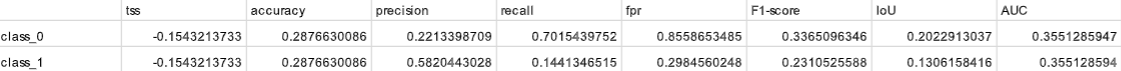

##### Training/validation

To start, we read in the training and validation data that was located in train_data_drone_new.pkl and validation_data_drone_new.pkl as shown here:

In [ ]:
with open(os.path.join(config['pickle_dir'], config['dataname'][0]), 'rb') as f:
    train_data = dill.load(f)

with open(os.path.join(config['pickle_dir'], config['dataname'][1]), 'rb') as f:
    validate_data = dill.load(f)

##### Getting Mean and Std from pkl

Note it turns out the means and stds called in here are not the correct ones.  

We are using hard-coded values in their place



In [ ]:
means = (0.44561575110266416, 0.510810310848835, 0.3085518195804729)
stds = (0.14633263550760425, 0.14759497867720306, 0.16548361469244469)

means, stds

((0.44561575110266416, 0.510810310848835, 0.3085518195804729),
 (0.14633263550760425, 0.14759497867720306, 0.16548361469244469))

Proceeded to load the training and validation data through a DataLoader function, as shown here:

##### Load data 

In [ ]:
# Note the train batch_size is set to 16
train_dataloader = DataLoader(train_data, batch_size = 16, shuffle=True,
                              drop_last=True)

# validation batch to 4
validate_dataloader = DataLoader(validate_data, batch_size=4, shuffle=False)


## Transfer Learning Below

Utilized the ModelCompiler function to bring in our Unet model, our pre-trained model, and also freeze the layers we are going to use to train the Model to be able to classify oil palm imagery. As shown, we used the “model” parameter as our Unet model, the params_init parameter as our pre-trained model, and the freeze_params parameter to list how many parameters from the Unet model to keep frozen

##### Model Compiler

In [ ]:
def get_optimizer(optimizer, params, lr, momentum):

    optimizer = optimizer.lower()
    if optimizer == 'sgd':
        return torch.optim.SGD(params, lr, momentum=momentum)
    elif optimizer == 'nesterov':
        return torch.optim.SGD(params, lr, momentum=momentum, nesterov=True)
    elif optimizer == 'adam':
        return torch.optim.Adam(params, lr)
    elif optimizer == 'amsgrad':
        return torch.optim.Adam(params, lr, amsgrad=True)
    else:
        raise ValueError(
            "{} currently not supported," \
            "please customize your optimizer in compiler.py".format(optimizer)
        )


def weighted_average_overlay(predDict, overlayPixels):

    if isinstance(predDict, dict):
        key_ls = ["top", "center", "left", "right", "bottom"]
        key_miss_ls = [m for m in predDict.keys() if m not in key_ls]
        if len(key_miss_ls) == 0:
            pass
        else:
            assert "Input must be dictionary containing data for centered image and its 4 neighbors."\
            "Missed {}".format(", ".join(key_miss_ls))
    else:
        assert "Input must be dictionary containing data for centered image and its 4 neighbors, " \
               "including including 'top', 'left', 'right', and  'bottom'"

    target = predDict['center']
    h, w = target.shape
    # top
    if predDict['top'] is not None:
        target_weight = np.array([1. / overlayPixels * np.arange(1, overlayPixels + 1)] * w).transpose(1, 0)
        comp_weight = 1. - target_weight
        # comp = scores_dict["up"][- overlay_pixs : , : ]
        target[:overlayPixels, :] = comp_weight * predDict['top'][- overlayPixels:, :] + \
                                   target_weight * target[:overlayPixels, :]
    else:
        pass
    # bottom
    if predDict['bottom'] is not None:
        target_weight = np.array([1. / overlayPixels * np.flip(np.arange(1, overlayPixels + 1))] * w).transpose(1, 0)
        comp_weight = 1. - target_weight
        target[-overlayPixels:, :] = comp_weight * predDict['bottom'][:overlayPixels, :] + \
                                    target_weight * target[-overlayPixels:, :]
    else:
        pass
    # left
    if predDict['left'] is not None:
        target_weight = np.array([1. / overlayPixels * np.arange(1, overlayPixels + 1)] * h)
        comp_weight = 1 - target_weight
        target[:, :overlayPixels] = comp_weight * predDict['left'][:, -overlayPixels:] + \
                                   target_weight * target[:, :overlayPixels]
    else:
        pass
    # right
    if predDict['right'] is not None:
        target_weight = np.array([1. / overlayPixels * np.flip(np.arange(1, overlayPixels + 1))] * h)
        comp_weight = 1 - target_weight
        target[:, -overlayPixels:] = comp_weight * predDict['right'][:, :overlayPixels] + \
                                    target_weight * target[:, -overlayPixels:]
    else:
        pass

    return target

class ModelCompiler:
    """
    Compiler of specified model
    Args:
        model (''nn.Module''): pytorch model for segmentation
        buffer (int): distance to sample edges not considered in optimization
        gpuDevices (list): indices of gpu devices to use
        params_init (dict object): initial model parameters
        freeze_params (list): list of indices for parameters to keep frozen
    """

    def __init__(self, model, buffer, gpuDevices=[0], params_init=None, 
                 freeze_params=None):
        
        self.working_dir = config["working_dir"]
        self.out_dir = config["out_dir"]

        # model
        self.gpuDevices = gpuDevices
        self.model = model

        self.model_name = self.model.__class__.__name__

        if params_init:
            self.load_params(params_init, freeze_params)

        self.buffer = buffer

        # gpu
        self.gpu = torch.cuda.is_available()

        if self.gpu:
            print('----------GPU available----------')
            # GPU setting
            if gpuDevices:
                torch.cuda.set_device(gpuDevices[0])
                self.model = torch.nn.DataParallel(self.model, 
                                                   device_ids=gpuDevices)
            self.model = self.model.cuda()

        num_params = sum(
            [p.numel() for p in self.model.parameters() 
             if p.requires_grad]
        )
        print("total number of trainable parameters: {:2.1f}M".format(num_params / 1000000))

        if params_init:
            print("-------- Pre-trained model compiled successfully --------")
        else:
            print("---------- Vanilla Model compiled successfully ----------")

    def load_params(self, dir_params, freeze_params):

        params_init = urlparse.urlparse(dir_params)

        inparams = torch.load(params_init.path)
        # inparams = torch.load(dir_params)

        ## overwrite model entries with new parameters
        model_dict = self.model.state_dict()

        if "module" in list(inparams.keys())[0]:
            inparams_filter = {
                k[7:]: v.cpu() for k, v in inparams.items() 
                if k[7:] in model_dict
            }

        else:
            inparams_filter = {
                k: v.cpu() for k, v in inparams.items() if k in model_dict
            }

        model_dict.update(inparams_filter)
        # load new state dict
        self.model.load_state_dict(model_dict)

        # free some layers
        if freeze_params != None:
            for i, p in enumerate(self.model.parameters()):
                if i in freeze_params:
                    p.requires_grad = False
        return self.model

    def fit(self, trainDataset, valDataset, epochs, optimizer_name, lr_init, 
            lr_policy, criterion, momentum=None, resume=False, 
            resume_epoch=None, model_dir=None, **kwargs):  
            ## 1. Note the addition of extra argument `model_dir`, which allows
            #     specific folder name for a model to be entered, enabling a 
            #     finetuning process to be restarted from a saved checkpoint. 
            #     Comment #2 below shows where the change is made. 
        
        # 2 added check for model_dir param to support restart from a checkpoint
        # when a different number of epochs is specified than that which was 
        # used to start the model. Previously this change would cause the 
        # generation of a new model_dir, preventing the model from finding the 
        # checkpoint file, even when specified. This is a hack that can be 
        # improved 
        if model_dir: 
            self.model_dir = config["model_dir"]
        else:
            # self.model_dir = "{}/{}/{}_ep{}".format(
            self.model_dir = "{}_ep{}".format(
                # self.working_dir, self.out_dir, config["model_name"], config["epochs"]
                config["model_name"], config["epochs"]
            )
        
        if not os.path.exists(Path(self.working_dir) / 
                              self.out_dir / self.model_dir):
            os.makedirs(Path(self.working_dir) / self.out_dir / self.model_dir)
        
        self.checkpoint_dir = Path(self.working_dir) / self.out_dir /\
            self.model_dir / "chkpt"
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
        
        os.chdir(Path(self.working_dir) / self.out_dir / self.model_dir)
        
        print("---------------------- Start training -----------------------")
        start = datetime.now()
        
        writer = SummaryWriter('./')
        lr = lr_init
        train_loss = []
        val_loss = []
        
        optimizer = get_optimizer(
            optimizer_name, 
            filter(lambda p: p.requires_grad, self.model.parameters()), lr, 
            momentum
        )

        # initialize different learning rate scheduler
        lr_policy = lr_policy.lower()
        if lr_policy == "StepLR".lower():
            step_size = kwargs.get("step_size", 10)
            gamma = kwargs.get("gamma", 0.5)
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=step_size, gamma=gamma)

        elif lr_policy == "MultiStepLR".lower():
            milestones = kwargs.get(
                "milestones", [10, 20, 30, 40, 50, 60, 70, 80, 90]
            )
            gamma = kwargs.get("gamma", 0.5)
            scheduler = torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=milestones, gamma=gamma,
            )

        elif lr_policy == "ReduceLROnPlateau".lower():
            mode = kwargs.get('mode', 'min')
            factor = kwargs.get('factor', 0.8)
            patience = kwargs.get('patience', 3)
            threshold = kwargs.get('threshold', 0.0001)
            threshold_mode = kwargs.get('threshold_mode', 'rel')
            min_lr = kwargs.get('min_lr', 3e-6)
            verbose = kwargs.get('verbose', True)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode=mode, factor=factor, patience=patience, 
                threshold=threshold, threshold_mode=threshold_mode, 
                min_lr=min_lr, verbose=verbose
            )

        elif lr_policy == "PolynomialLR".lower():
            max_decay_steps = kwargs.get('max_decay_steps', 100)
            min_learning_rate = kwargs.get('min_learning_rate', 1e-5)
            power = kwargs.get('power', 0.8)
            scheduler = PolynomialLR(
                optimizer, max_decay_steps=max_decay_steps, 
                min_learning_rate=min_learning_rate,
                power=power
            )

        elif lr_policy == "CyclicLR".lower():
            base_lr = kwargs.get('base_lr', 3e-5)
            max_lr = kwargs.get('max_lr', 0.01)
            step_size_up = kwargs.get('step_size_up', 1100)
            mode =  kwargs.get('mode', 'triangular')
            scheduler = torch.optim.lr_scheduler.CyclicLR(
                optimizer, base_lr=base_lr, max_lr=max_lr, 
                step_size_up=step_size_up, mode=mode
            )

        else:
            scheduler = None

        if resume:
            model_state_file = os.path.join(
                self.checkpoint_dir,
                f"{resume_epoch}_checkpoint.pth.tar"
            )

            # Resume the model from the specified checkpoint in the config file.
            if os.path.exists(model_state_file):
                print(f"Model is resumed from checkpoint: {model_state_file}")
                checkpoint = torch.load(model_state_file)
                resume_epoch = checkpoint["epoch"]
                scheduler.load_state_dict(checkpoint["scheduler"])
                self.model.load_state_dict(checkpoint["state_dict"])
                optimizer.load_state_dict(checkpoint["optimizer"])
                train_loss = checkpoint["train_loss"]
                val_loss = checkpoint["val_loss"]
            else:
                raise ValueError(f"{model_state_file} does not exist")

        if resume:
            iterable = range(resume_epoch, epochs)
        else:
            iterable = range(epochs)

        for t in iterable:

            print(f"[{t+1}/{epochs}]")

            # start fitting
            start_epoch = datetime.now()
            train(trainDataset, self.model, criterion, optimizer, scheduler, 
                  gpu=self.gpu, trainLoss=train_loss)
            validate(valDataset, self.model, criterion, 0, 
                     gpu=self.gpu, valLoss=val_loss)

            # Update the scheduler
            if lr_policy in ["StepLR".lower(), "MultiStepLR".lower()]:
                scheduler.step()
                print(f"LR: {scheduler.get_last_lr()}")

            if lr_policy == "ReduceLROnPlateau".lower():
                scheduler.step(val_loss[t])

            if lr_policy == "PolynomialLR".lower():
                scheduler.step(t)
                print(f"LR: {optimizer.param_groups[0]['lr']}")

            # time spent on single iteration
            print('time:', (datetime.now() - start_epoch).seconds)

            writer.add_scalars(
                "Loss",
                {"train_loss": train_loss[t],
                 "val_loss": val_loss[t]},
                 t + 1)

            checkpoint_interval = 4 # e.g. save every 4 epochs
            if (t+1) % checkpoint_interval == 0:
                torch.save(
                    {
                        "epoch": t+1,
                        "state_dict": self.model.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "train_loss": train_loss,
                        "val_loss": val_loss
                    }, os.path.join(
                        self.checkpoint_dir,
                        f"{t+1}_checkpoint.pth.tar")
                )

        writer.close()
        return train_loss, val_loss
        print(f"-------------------------- Training finished in ", 
              f"{(datetime.now() - start).seconds}s --------------------------")


    def evaluate(self, evalDataset, csv_fn):

        if not os.path.exists(Path(self.working_dir) / self.out_dir):
            os.makedirs(Path(self.working_dir) / self.out_dir)
        
        print('---------------------- Start evaluation -------------------')
        start = datetime.now()
        
        # evaluate(evalData, model, buffer, gpu, csv_fn)
        print(start)
        evaluate(evalDataset, self.model, self.buffer, self.gpu, csv_fn)

        print(
            f"---------------------- Evaluation finished in ", 
            f"{(datetime.now() - start).seconds}s --------------------------"
        )

    def predict(self, predDataset, outPrefix, #mc_samples=None, 
                predBuffer=None, #averageNeighbors=False, 
                shrinkBuffer=0, 
                filename=""):
    
        print('---------------------- Start prediction ---------------------')
        start = datetime.now()

        _, meta = predDataset
        # name_score = f"{year}_c{tile[0]}_r{tile[1]}{filename}.tif"
        name_score = f"{filename}_pred.tif"
        meta.update({
            'dtype': 'int16'
        })

        prefix_score = os.path.join(outPrefix, "Score")
        new_buffer = predBuffer - shrinkBuffer
    
        scores = predict(predDataset, self.model, predBuffer, gpu=self.gpu, 
                         shrinkPixel=shrinkBuffer)
        # write score of each non-background class
        nclass = len(scores)
        for n in range(nclass):
            canvas = scores[n][new_buffer: meta['height'] + new_buffer, 
                               new_buffer: meta['width'] + new_buffer]
            canvas = canvas.astype(meta['dtype'])

            with rasterio.open(f"{prefix_score}_{n + 1}_{name_score}", "w", 
                               **meta) as dst:
                dst.write(canvas, indexes=1)

        print(f"------------------ ",  
              f"Prediction finished in {(datetime.now() - start).seconds}",
              f"----------------------")
        
        return scores
    
    def save(self, name, object = "params"):
        
        if object == "params":
            torch.save(self.model.state_dict(), 
                       os.path.join(self.checkpoint_dir, 
                                    "{}_final_state.pth".format(name)))
            
            print("----------------- " \
                  "Model parameters saved to disk ------------------")
        
        elif object == "model":
            torch.save(self.model, 
                       os.path.join(self.checkpoint_dir, 
                                    "{}_final_state.pth".format(name)))
        
        else:
            raise ValueError("Improper object type.")

### Compile model

In [ ]:
model = unet(config["img_bands"], config["class_numbers"], config["drop_rate"])
model = ModelCompiler(
    model=model,
    buffer=config["buffer"],
    gpuDevices=config["gpus"],
    params_init=str(config['init_params']),
    freeze_params=config["freeze_params"]
)

----------GPU available----------
total number of trainable parameters: 0.1M
-------- Pre-trained model compiled successfully --------


### Train or Finetune 

Fit the model to perform the actual finetuning and then save the model which we will use for prediction

In [ ]:
# """Warning: BE PATIENT- this process could take a long time (approx. 20-25 mins)"""
train_loss, valid_loss = model.fit(
    trainDataset=train_dataloader,
    valDataset=validate_dataloader, 
    epochs=config["epochs"], 
    optimizer_name=config["optimizer"], 
    lr_init=config["lr_init"], 
    lr_policy=config["LR_policy"],
    criterion=config["criterion"], 
    momentum = config["momentum"],
    resume = config["resume"], 
    resume_epoch = config["resume_epoch"],
    model_dir = config["model_dir"]  # note added model_dir parameter
)


---------------------- Start training -----------------------
[1/20]
train loss:0.6023565971139652
validation loss: 0.5875226696463007
LR: [0.01]
time: 79
[2/20]
train loss:0.5369157172850708
validation loss: 0.5800089823049411
LR: [0.01]
time: 70
[3/20]
train loss:0.5197727752858726
validation loss: 0.5847837504064828
LR: [0.01]
time: 71
[4/20]
train loss:0.5226133238913407
validation loss: 0.6072723804074421
LR: [0.01]
time: 71
[5/20]
train loss:0.517181278164707
validation loss: 0.5553183920289341
LR: [0.01]
time: 70
[6/20]
train loss:0.508857622223707
validation loss: 0.5646444420542633
LR: [0.01]
time: 70
[7/20]
train loss:0.5081279578790143
validation loss: 0.5650536872838673
LR: [0.01]
time: 70
[8/20]
train loss:0.50364982725969
validation loss: 0.5707067009388355
LR: [0.01]
time: 70
[9/20]
train loss:0.5030838778956019
validation loss: 0.5646081534132623
LR: [0.01]
time: 69
[10/20]
train loss:0.49536565450293507
validation loss: 0.5466352597924701
LR: [0.005]
time: 70
[11/20]
t

Change saved model name each time the above training code is run

In [ ]:
model.save("Hanxi_finetune_ep20", object="params")

----------------- Model parameters saved to disk ------------------


## Evaluate 

In [ ]:
config["model_dir"] = "unet_ep20" # turn this off if non None in initial config

In [ ]:
csv_fn = Path(config["working_dir"]) / config["out_dir"] / \
    config["model_dir"] / "validation_metrics.csv"
metrics = model.evaluate(validate_dataloader, csv_fn=str(csv_fn))

---------------------- Start evaluation -------------------
2023-05-15 19:25:17.312437
start
2
              tss  accuracy  precision    recall       fpr  F1-score  \
class_0  0.483396  0.770653   0.543558  0.682000  0.198603  0.604959   
class_1  0.483396  0.770653   0.879038  0.801397  0.318000  0.838424   

              IoU       AUC  
class_0  0.433650  0.814226  
class_1  0.721798  0.814226  
---------------------- Evaluation finished in  1447s --------------------------


Read the metrics back in after writing to csv, using pandas to get a nicer print of the metrics. 

In [ ]:
metrics = pd.read_csv(csv_fn)
metrics.rename(columns={metrics.columns[0]: "class"}, inplace=True)
metrics

class       tss  accuracy  precision    recall       fpr  F1-score  \
0  class_0  0.483396  0.770653   0.543558  0.682000  0.198603  0.604959   
1  class_1  0.483396  0.770653   0.879038  0.801397  0.318000  0.838424   

        IoU       AUC  
0  0.433650  0.814226  
1  0.721798  0.814226

## Predictions

### Catalog

In [ ]:
catalog = pd.read_csv(
    Path(proj_dir) / "working" / config["catalog_pred_fn"]
)

predict_catalog = catalog[catalog.usage=='validate']\
    .sample(n=10, random_state=1)
predict_catalog.reset_index(drop=True, inplace=True)
predict_catalog

ortho                              labels  \
0  ortho_cid1802_sid318_cog_rs.tif   label_ortho_cid1802_sid318_83.tif   
1   ortho_cid1344_sid37_cog_rs.tif   label_ortho_cid1344_sid37_116.tif   
2   ortho_cid1344_sid37_cog_rs.tif    label_ortho_cid1344_sid37_54.tif   
3  ortho_cid1802_sid318_cog_rs.tif  label_ortho_cid1802_sid318_176.tif   
4  ortho_cid1802_sid318_cog_rs.tif   label_ortho_cid1802_sid318_53.tif   
5  ortho_cid1802_sid251_cog_rs.tif  label_ortho_cid1802_sid251_245.tif   
6  ortho_cid1839_sid143_cog_rs.tif   label_ortho_cid1839_sid143_43.tif   
7  ortho_cid1670_sid157_cog_rs.tif   label_ortho_cid1670_sid157_15.tif   
8  ortho_cid1477_sid357_cog_rs.tif  label_ortho_cid1477_sid357_118.tif   
9  ortho_cid1802_sid251_cog_rs.tif  label_ortho_cid1802_sid251_303.tif   

                                images     usage  
0   ortho_cid1802_sid318_cog_rs_83.tif  validate  
1   ortho_cid1344_sid37_cog_rs_116.tif  validate  
2    ortho_cid1344_sid37_cog_rs_54.tif  validate  
3  ortho_cid1802_sid318_cog_rs_176.tif  validate  
4   ortho_cid1802_sid318_cog_rs_53.tif  validate  
5  ortho_cid1802_sid251_cog_rs_245.tif  validate  
6   ortho_cid1839_sid143_cog_rs_43.tif  validate  
7   ortho_cid1670_sid157_cog_rs_15.tif  validate  
8  ortho_cid1477_sid357_cog_rs_118.tif  validate  
9  ortho_cid1802_sid251_cog_rs_303.tif  validate

### Update config to point to saved model parameters

Note that we can use the other variables in the config file to form a path to where the final model parameters are stored within the "chkpt" directory. You need to look into the directory to s

In [ ]:
config["model_dir"] = "unet_ep20" # Change to correct model directory
config["init_params"] = Path(config["working_dir"]) / config["out_dir"] /\
    config["model_dir"] / "chkpt" /\
    "Hanxi_finetune_ep20_final_state.pth" # add correct parameter file
config["init_params"]

PosixPath('/content/gdrive/MyDrive/Clark/Deep_Learning/drones/working/southern/JasonOutput/predictions/unet_ep20/chkpt/Hanxi_finetune_ep20_final_state.pth')

### Run predictions

Note we first make a directory to write the predictions to. Here we make them in a sub-folder of the demo directory called "pred_chips" and then specify with another sub-folder which model name the predictions came from. 

One path-making thing to note. You will see here (and in places) above where `Path` is used and the full path is broken across two lines (to prevent going beyond 80 characters). The \ enables that, but it won't work if there is a space after it (python will complain).  It can be hard to figure that out because the spaces is invisible. 

In [ ]:
pred_dir = Path(config["working_dir"]) / config["out_dir"] / "pred_chips" /\
    config["model_dir"]

# make pred_dir if it doesn't exist
pred_dir.mkdir(parents=True, exist_ok=True)
pred_dir

PosixPath('/content/gdrive/MyDrive/Clark/Deep_Learning/drones/working/southern/JasonOutput/predictions/pred_chips/unet_ep20')

### Updated some config parameters

In [ ]:
config["patch_size"] = 224
config["window"] = (15, 15, 224, 224)

### Compile model again for prediction

In [ ]:
model = unet(config["img_bands"], config["class_numbers"], config["drop_rate"])
model = ModelCompiler(
    model=model, 
    buffer=config["buffer"], 
    gpuDevices=config["gpus"], 
    params_init=str(config["init_params"])  # note path needs to be str
)

----------GPU available----------
total number of trainable parameters: 13.4M
-------- Pre-trained model compiled successfully --------


References predict_catalog.csv to point the trained model towards the 10 images that prediction will be done on.

Output of this function are three lists containing the corresponding image, label, and prediction data for each of the 10 images.

In [ ]:
scores = []
imgs = []
lbls = []
for i, row in predict_catalog.iterrows():

    print("--------------------- Start Inference(Test) ---------------------")
    start = datetime.now()
    
    lbl_file = Path(proj_dir) / "working/southern/label_chips"/ row["labels"]
    lbl, meta = load_data(lbl_file, usage="train", isLabel=True, 
                          window=(15, 15, 224, 224))
    lbls.append(lbl)

    img_file = Path(proj_dir) / "working/southern/image_chips" / row["images"]
    img, meta = load_data(
        img_file, usage="predict", isLabel=False, 
        normalize=True, window=(15, 15, 224, 224), 
        means=means, stds=means
    )
    imgs.append(img)

    # predictions
    pred_data = load_dataset(predict_catalog, config, "predict", i)
    out_name = re.sub("ortho_|_cog_rs.tif", "", predict_catalog.loc[i]['ortho'])
    print(out_name)
    score = model.predict(pred_data, pred_dir, 0, 0, out_name)
    scores.append(score)

--------------------- Start Inference(Test) ---------------------
-----------1 image loaded in prediction dataset---------
cid1802_sid318
---------------------- Start prediction ---------------------
Getting prediction image
------------------  Prediction finished in 3 ----------------------
--------------------- Start Inference(Test) ---------------------
-----------1 image loaded in prediction dataset---------
cid1344_sid37
---------------------- Start prediction ---------------------
Getting prediction image
------------------  Prediction finished in 0 ----------------------
--------------------- Start Inference(Test) ---------------------
-----------1 image loaded in prediction dataset---------
cid1344_sid37
---------------------- Start prediction ---------------------
Getting prediction image
------------------  Prediction finished in 0 ----------------------
--------------------- Start Inference(Test) ---------------------
-----------1 image loaded in prediction dataset---------


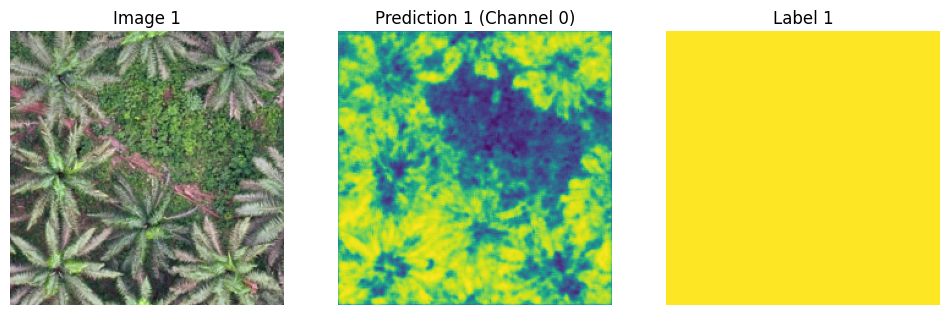

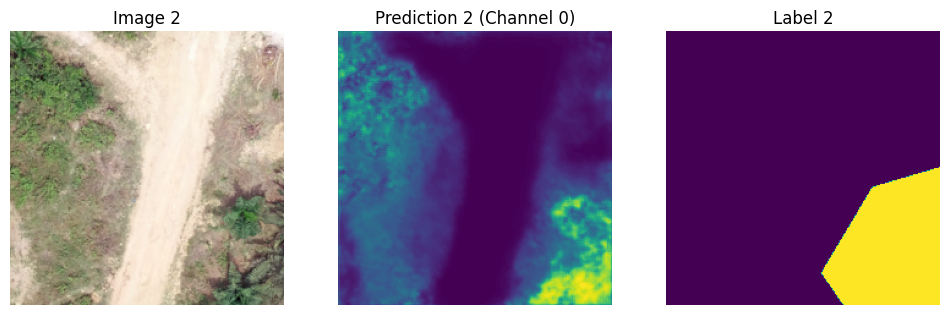

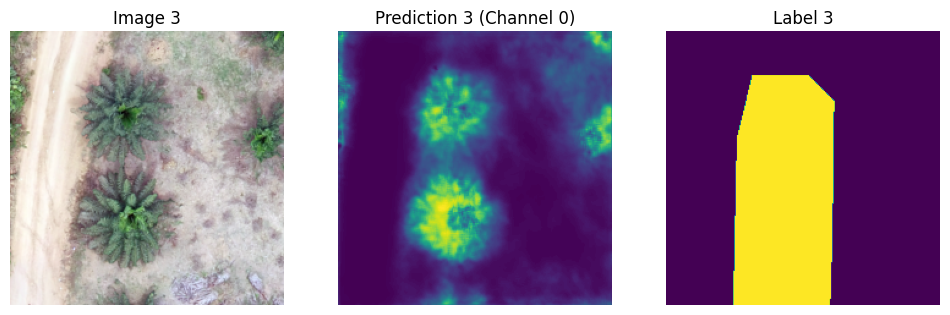

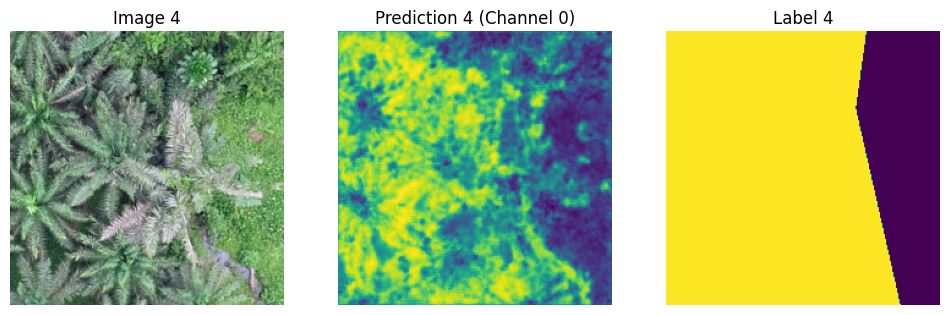

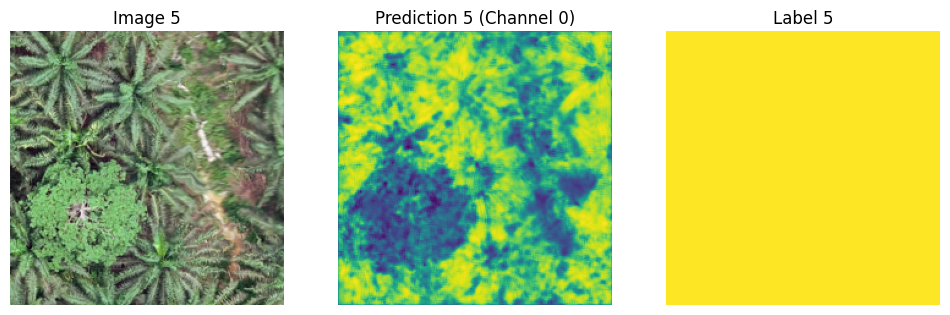

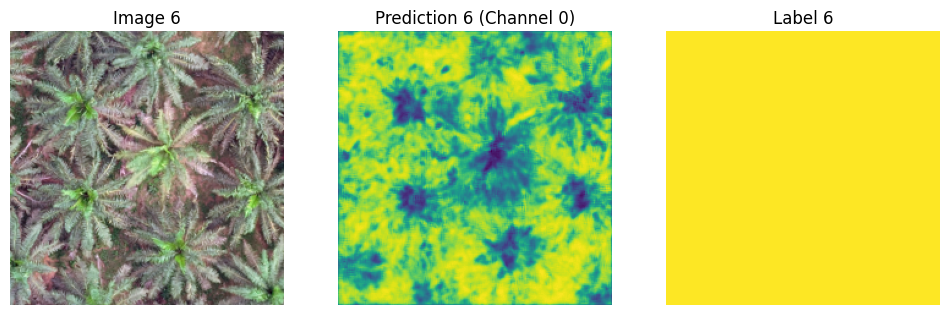

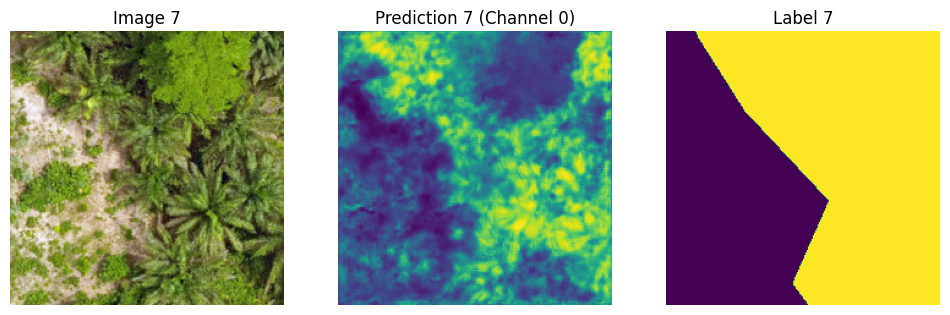

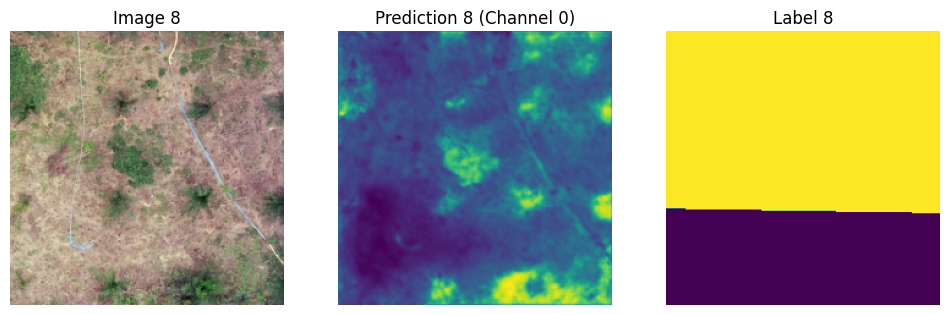

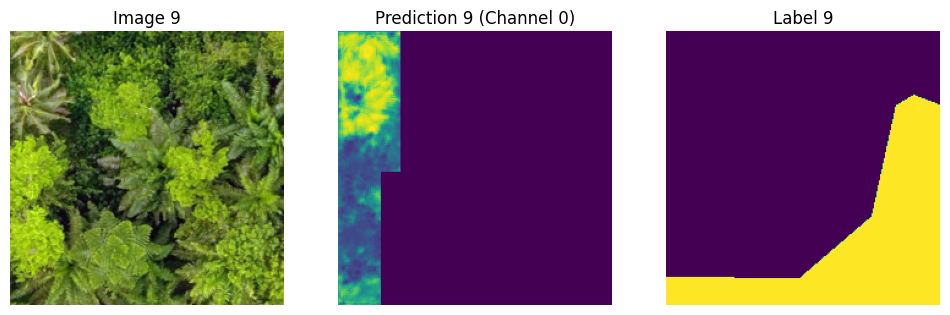

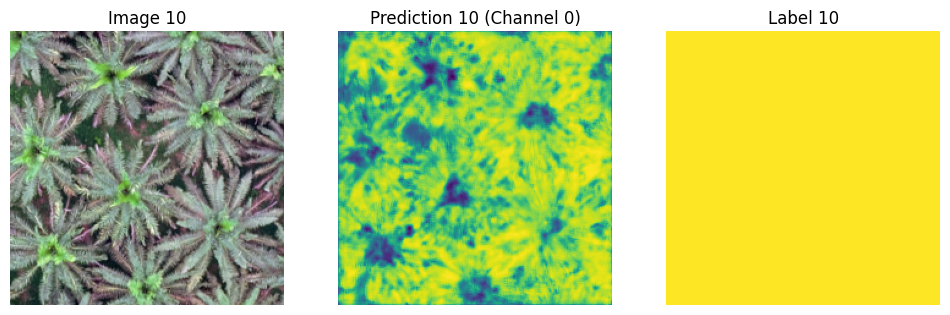

In [ ]:
for i in range(len(scores)):
  plot_predictions(imgs[i], scores[i][0], lbls[i])

##**4. Discussion:**

The main obstacles that we faced were creating the custom data loader and also figuring out how all the code needed for performing transfer learning worked. There were many steps to understand when creating the data loader, and even when the code itself worked, the data files that the data loader was supposed to retrieve were in the wrong spots, making it unable to get all the necessary data. Therefore, we had to switch to using a different data loader that created two pickle files individually storing training and validation data. There were many other issues that occurred after the fact, like the data being corrupted and having to re-upload new pickle files with the correct data, which took a lot of time. Once we had the correct data, we started developing the transfer learning code and encountered various issues along the way. For example, there was a lot of code that seemed like it was unnecessary for what we were trying to do, which made it difficult to understand which code to run and what to leave alone. An additional stumbling block, even after having successfully trained the model and evaluated validation performance (which required purchasing a ColabPro subscription), was the prediction data loader, which reads in data to be fed into the trained model for prediction to be performed on.


Zooming out, we might have benefited from additional time to work on this project and parse the different code blocks that we were sent. We struggled at times to know exactly what code should be used, and on more than one occasion spent hours working on a notebook that was not actually going to be useful or relevant.  Issues with data on the front end are pretty much inevitable in a project like this, but it would have been cool to have more time to work on manipulating/freezing parameters, and focusing on the more theoretical aspects of transfer learning. 
